In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
import itertools
import pickle
from sklearn.preprocessing import normalize

%matplotlib inline

# %% load metadata
df = pd.read_pickle('/home/frati/Grasping/Squared/metadata.pkl.compress', compression='gzip')
ix_to_obj = list(pd.read_pickle('/home/frati/Grasping/Squared/index.pkl.compress', compression='gzip'))
obj_to_ix = {}
for idx,el in enumerate(list(ix_to_obj)):
    obj_to_ix[el] = idx

In [2]:
class TagVocabulary():
    def __init__(self, tags_to_ix_path):
        with open(tags_to_ix_path,'rb') as f:
                self.tags_to_ix = pickle.load(f)
        self.ix_to_tag = {val:key for key,val in self.tags_to_ix.items()}
        self.stop = self.convert_tag('STOP')
    
    def __len__(self):
        return len(self.tags_to_ix)
    
    def __call__(self,tags):
        s_tags = map(lambda x: ''.join(sorted(x)),tags)
        c_tags = list(map(lambda x: self.convert_tag(x), s_tags))
        c_tags.append(self.stop)
        return torch.LongTensor(c_tags)
    
    def convert_tag(self,tag):
        s_tag = ''.join(sorted(tag))
        if not s_tag in self.tags_to_ix:
            s_tag = 'KNU'
        return self.tags_to_ix[s_tag]
    
    def revert_to_tag(self,num):
        return self.ix_to_tag[num]
    
    def is_stop(self,tag):
        return tag == self.stop

In [3]:
vocab = TagVocabulary('/home/frati/Grasping/code/data/tags_to_ix.pkl')

In [4]:
df = df[df['hot'] == False] # exclude hot
df = df[df['impaired'] == False] # exclude impaired
df = df[df['failed'] == False] # exclude failed
df.index = list(range(len(df)))
df = df[['new_location','object','labels']]

In [5]:
df.iloc[0]

new_location    subject01/51-cigarette
object                       cigarette
labels                    [atu, c2tgr]
Name: 0, dtype: object

In [6]:
# Counter can't work with lists so we stringify them
def stringify(x):
    return ' '.join(x)
def listify(x):
    return x.split(' ')

In [7]:
labels = list(df['labels'].apply(stringify))

In [8]:
from collections import Counter

In [9]:
Counter(labels).most_common()

[('atu c2tgn', 220),
 ('atu c2tgr', 194),
 ('atu c3tgn', 178),
 ('atu mtgl eg', 83),
 ('atu c2tgn fp', 78),
 ('atu c3tun', 63),
 ('atu mtgd eg', 43),
 ('atu c3tgr', 41),
 ('atu c2tun', 40),
 ('atu c4tgn', 37),
 ('abu c3bgn', 32),
 ('atu c2tgr fp', 29),
 ('atu c3tgn fp', 28),
 ('atu mtgl eu', 27),
 ('abu c3bun', 22),
 ('atu c4tun', 20),
 ('abg c3bgn', 16),
 ('atu c2tgn fq', 11),
 ('atu c4tgr', 11),
 ('atu mtul eg', 11),
 ('atu c2sun', 11),
 ('atu mtul eu', 11),
 ('atu c3tgr fp', 11),
 ('atg c2tgr', 10),
 ('atu c2sgn', 9),
 ('atu c3tgn fq', 9),
 ('asu o c3sur', 9),
 ('atu mtgd eu', 8),
 ('atu c2tgd', 8),
 ('atu c2tgr fq', 8),
 ('abu c2bgn', 8),
 ('abu c4bgn', 8),
 ('asu c4sun', 8),
 ('atg c2tgn', 8),
 ('asu c4sgn', 8),
 ('atu fp', 8),
 ('asu c3sgn', 7),
 ('asu c2sun', 7),
 ('atu c5tun', 6),
 ('atu c3tgl', 6),
 ('atg c3tgn', 6),
 ('asg c2sgn', 6),
 ('atu mtud eu', 5),
 ('asu c5sun', 5),
 ('atu c2tur', 5),
 ('atu o fp', 5),
 ('atu mtud eg', 4),
 ('atu c3tgd', 4),
 ('atu c3tur', 4),
 ('abg 

In [10]:
vocab.convert_tag('c2tgn')

3100

In [12]:
first_tags = [x[0] for x in df['labels']]

In [13]:
Counter(first_tags).most_common()

[('atu', 1390),
 ('abu', 84),
 ('asu', 75),
 ('atg', 44),
 ('abg', 25),
 ('asg', 11),
 ('o', 2)]

In [14]:
second_tags = [x[1] for x in df['labels']]

In [15]:
Counter(second_tags).most_common()

[('c2tgn', 322),
 ('c2tgr', 250),
 ('c3tgn', 228),
 ('mtgl', 111),
 ('o', 82),
 ('mtgd', 65),
 ('c3tun', 64),
 ('c3tgr', 56),
 ('c3bgn', 50),
 ('c4tgn', 43),
 ('c2tun', 41),
 ('mtul', 24),
 ('c3bun', 24),
 ('c4tun', 22),
 ('c2sgn', 20),
 ('mtud', 20),
 ('c2sun', 19),
 ('c2tgd', 16),
 ('c4tgr', 13),
 ('c3sgn', 13),
 ('c4bgn', 11),
 ('c3tgl', 11),
 ('c2bgn', 10),
 ('c4sun', 10),
 ('c4sgn', 9),
 ('c3tgd', 8),
 ('c?bgn', 8),
 ('fp', 8),
 ('c5tun', 6),
 ('c5bgn', 5),
 ('c5sun', 5),
 ('c2tur', 5),
 ('msur', 4),
 ('c3tur', 4),
 ('c2bun', 4),
 ('c?tgn', 3),
 ('c3sun', 3),
 ('c4tgl', 3),
 ('mtgr', 3),
 ('c4bun', 2),
 ('atu', 2),
 ('mtur', 2),
 ('c?tgd', 2),
 ('c5tgn', 2),
 ('c3sur', 2),
 ('c2sud', 1),
 ('c3sud', 1),
 ('c?sgn', 1),
 ('c4bul', 1),
 ('c?bur', 1),
 ('c4sgr', 1),
 ('c2tgl', 1),
 ('c5tgl', 1),
 ('c3sgl', 1),
 ('c5tgr', 1),
 ('c5tul', 1),
 ('c?bgr', 1),
 ('c2bur', 1),
 ('c5bgr', 1),
 ('c3bgr', 1),
 ('msgd', 1)]

In [16]:
third_tags = [x[2] if len(x) >= 3 else 'none' for x in df['labels'] ]

In [17]:
Counter(third_tags).most_common()

[('none', 1092),
 ('fp', 187),
 ('eg', 142),
 ('eu', 51),
 ('fq', 35),
 ('o', 27),
 ('mtgd', 16),
 ('mtgl', 14),
 ('c3sur', 9),
 ('mtul', 6),
 ('mtur', 4),
 ('c2tgn', 4),
 ('c3tgr', 4),
 ('c3sgr', 4),
 ('mtud', 3),
 ('msur', 3),
 ('c2tgr', 3),
 ('c4sun', 2),
 ('c4tgn', 2),
 ('c5tgr', 2),
 ('c3sud', 2),
 ('c3tgn', 2),
 ('c4tur', 1),
 ('c5sur', 1),
 ('c?sur', 1),
 ('c5tun', 1),
 ('c?bgn', 1),
 ('c?tgl', 1),
 ('c?tgn', 1),
 ('c4sud', 1),
 ('c3sun', 1),
 ('msud', 1),
 ('msgr', 1),
 ('mtgr', 1),
 ('c3bgn', 1),
 ('fw', 1),
 ('c2sgr', 1),
 ('c3bun', 1),
 ('c4tgr', 1)]

In [18]:
df['str_labels'] = df['labels'].apply(stringify)

In [19]:
objects = df.object.unique()

In [20]:
labels_per_object = {}
for obj in objects:
    labels_per_object[obj] = Counter(df[df['object'] == obj]['str_labels']).most_common()

In [21]:
variability_per_object = []
for key,val in labels_per_object.items():
    variability_per_object.append((key,len(val),sum([x[1] for x in val])))
    
variability_per_object = sorted(variability_per_object,key=lambda x: x[1], reverse=True)
print("{:12}{:10}{:5}".format("Object:", "options:","trials:"))
tot = 0
for obj,opts,trials in variability_per_object:
    print("{:14}{:<10}{:<5}".format(obj,opts,trials))
    tot += trials
print("Total: ",tot)

Object:     options:  trials:
book          42        56   
coffee_mug    33        69   
comb          26        52   
screw_driver  26        70   
plate         26        70   
bowl          23        69   
glasses       21        69   
toy           19        69   
key           18        49   
shashlik      17        61   
french_chalk  17        69   
game_card     16        61   
salt_shaker   15        70   
credit_card   13        57   
matchbox      13        70   
cd            12        58   
button        11        66   
match         10        69   
marker        10        69   
tape          10        70   
shell         7         69   
screw         7         70   
cigarette     5         59   
chestnut      5         70   
rubber_band   2         70   
Total:  1631


In [22]:
labels_per_object['rubber_band']

[('atu c2tgn', 69), ('atg c2tgn', 1)]

In [23]:
label_per_object_thresh = {}
for key, val in labels_per_object.items():
    label_per_object_thresh[key] = [x for x in val if x[1] > 2 ]

t_variability = []
for key,val in label_per_object_thresh.items():
    t_variability.append((key,len(val),sum([x[1] for x in val])))
    
t_variability = sorted(t_variability,key=lambda x: x[1], reverse=True)

print("{:12}{:10}{:5}".format("Object:", "options:","trials:"))
tot = 0
for obj,opts,trials in t_variability:
    print("{:14}{:<10}{:<5}".format(obj,opts,trials))
    tot += trials
print("Total: ",tot)

Object:     options:  trials:
salt_shaker   9         62   
glasses       9         56   
toy           8         57   
comb          7         32   
coffee_mug    7         40   
screw_driver  6         48   
key           6         36   
french_chalk  5         55   
matchbox      5         62   
bowl          5         46   
plate         5         46   
button        5         60   
marker        4         61   
tape          4         62   
screw         4         66   
game_card     4         48   
cd            4         48   
shell         3         64   
shashlik      3         44   
match         3         61   
book          3         9    
chestnut      3         67   
cigarette     2         55   
credit_card   2         42   
rubber_band   1         69   
Total:  1296


In [24]:
list_per_obj = {}
for key,val in labels_per_object.items():
    list_per_obj[key] = [(listify(label),count) for label,count in val]

In [25]:
list_per_obj

{'cigarette': [(['atu', 'c2tgr'], 51),
  (['atu', 'c3tgr'], 4),
  (['atu', 'c2tgn'], 2),
  (['atg', 'c2tgr'], 1),
  (['atu', 'c2tgd'], 1)],
 'comb': [(['atu', 'c2tgr', 'fp'], 9),
  (['atu', 'c2tgr', 'fq'], 5),
  (['atu', 'c3tgr', 'fp'], 4),
  (['atu', 'c2tgn', 'fq'], 4),
  (['atu', 'fp'], 4),
  (['atu', 'c2tgd', 'fp'], 3),
  (['atu', 'c2tgn', 'fp'], 3),
  (['atu', 'mtgd', 'eg'], 2),
  (['atu', 'c2tgr', 'mtgd', 'eg'], 1),
  (['atu', 'c4tgn', 'fq'], 1),
  (['atu', 'c4tgr', 'fp'], 1),
  (['atg', 'c3tgr', 'fp'], 1),
  (['atg', 'c2tgr', 'mtgd', 'eg'], 1),
  (['atg', 'c?tgd', 'mtgd', 'eg'], 1),
  (['atu', 'mtgd', 'o', 'c3tgr', 'fp'], 1),
  (['atu', 'mtgd', 'o', 'mtgd', 'eg'], 1),
  (['atu', 'mtgd', 'o', 'mtgl', 'eg'], 1),
  (['atu', 'mtgd', 'eu'], 1),
  (['atu', 'o', 'mtgd', 'o', 'eg'], 1),
  (['atu', 'mtgl', 'eg'], 1),
  (['atu', 'c2tgd', 'mtgd', 'eg'], 1),
  (['atu', 'c2tgr', 'mtgd', 'fq'], 1),
  (['atu', 'c3tgd', 'fq'], 1),
  (['atu', 'c3tgn', 'fp'], 1),
  (['atu', 'o', 'fp'], 1),
  (['at

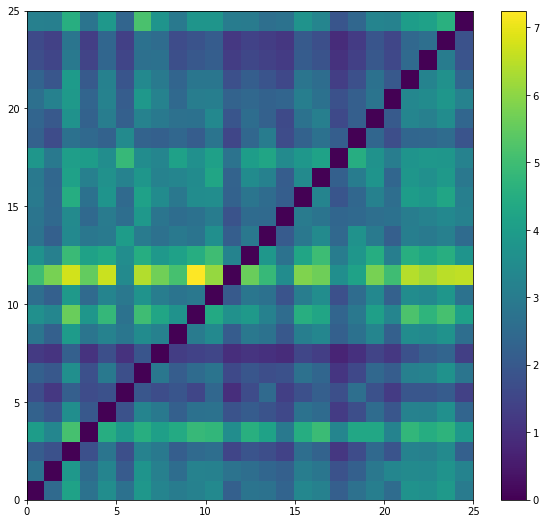

In [26]:
corr = np.zeros((len(ix_to_obj),len(ix_to_obj)))
for obj_i in objects:
    for obj_j in objects:
        if obj_i != obj_j:
            overlap = 0
            tot = 0
            for labels_i, count_i in labels_per_object[obj_i][1:]:
                for labels_j, count_j in labels_per_object[obj_j][1:]:
                    tot += count_i
                    for label_i, label_j in zip(labels_i,labels_j):
                        if label_i == label_j:
                            overlap += min(count_i,count_j)
                corr[obj_to_ix[obj_i],obj_to_ix[obj_j]] = overlap/tot

#plt.imshow(corr, cmap='hot', interpolation='nearest')
plt.figure(figsize=(10,9))
plt.pcolor(corr)
plt.colorbar()

In [27]:
flat_obj = ['key','button','cd','credit_card','game_card','comb']
tall_obj = ['glasses','matchbox','chestnut','toy','salt_shaker','tape']
big_obj = ['book','bowl','plate','coffee_mug']
long_obj = ['cigarette','marker','screw_driver', 'shashlik']
small_obj = [ 'french_chalk',  'match', 'rubber_band', 'screw', 'shell']

print(len(flat_obj+tall_obj+big_obj+long_obj+small_obj))

obj_categories = {'flat' : flat_obj,
                  'tall' : tall_obj,
                  'big'  : big_obj,
                  'long' : long_obj,
                  'small': small_obj}

25


In [28]:
obj_to_category = {}
for category, objects in obj_categories.items():
    for obj in objects:
        obj_to_category[obj] = category

print(obj_to_category)

{'key': 'flat', 'button': 'flat', 'cd': 'flat', 'credit_card': 'flat', 'game_card': 'flat', 'comb': 'flat', 'glasses': 'tall', 'matchbox': 'tall', 'chestnut': 'tall', 'toy': 'tall', 'salt_shaker': 'tall', 'tape': 'tall', 'book': 'big', 'bowl': 'big', 'plate': 'big', 'coffee_mug': 'big', 'cigarette': 'long', 'marker': 'long', 'screw_driver': 'long', 'shashlik': 'long', 'french_chalk': 'small', 'match': 'small', 'rubber_band': 'small', 'screw': 'small', 'shell': 'small'}


(200,)


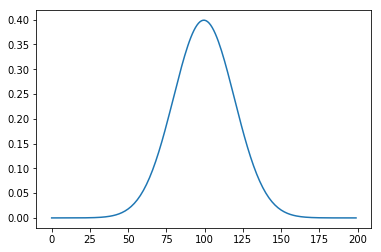

In [29]:
from scipy.stats import norm

x_axis = np.linspace(-5,5, num=200)
gauss_ker = norm.pdf(x_axis,0,1)
print(gauss_ker.shape)
plt.plot(gauss_ker)

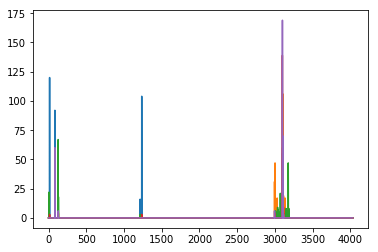

In [30]:
def compute_distr(obj_type, data_obj, vocab):
    distr = np.zeros(len(vocab))
    excluded = 'atu'
    for obj in obj_type:
        for label in data_obj[obj]:
            for tag in label[0].split(' '):
                if tag != excluded:
                    distr[vocab.convert_tag(tag)] += label[1]
    return distr

obj_distr = {}
for category,objs in obj_categories.items():
    obj_distr[category] = compute_distr(objs, label_per_object_thresh, vocab)
    
for distr in obj_distr.values():
    plt.plot(distr)
    
#flat_obj_distribution = compute_distr(flat_obj, label_per_object_thresh, vocab)
#tall_obj_distribution = compute_distr(tall_obj, label_per_object_thresh, vocab)
#big_obj_distribution = compute_distr(big_obj, label_per_object_thresh, vocab)
#long_obj_distribution = compute_distr(long_obj, label_per_object_thresh, vocab)
#small_obj_distribution = compute_distr(small_obj, label_per_object_thresh, vocab)

#for obj in flat_obj:
#    for label in label_per_object_thresh[obj]:
#        for tag in label[0].split(' '):
#            if tag != excluded:
#                flat_obj_distribution[vocab.convert_tag(tag)] += label[1]


#flat_obj_distribution /= flat_obj_distribution.sum()

In [31]:
# parameters of gaussian
gauss_mean = 0
gauss_std = 0.5

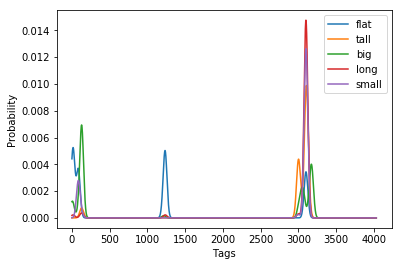

In [33]:
def flatten_and_norm(distr):
    x_axis = np.linspace(-5,5, num=500)
    gauss_ker = norm.pdf(x_axis,0,gauss_std)
    smooth_distribution = np.convolve(distr,gauss_ker,'same')
    norm_distribution = smooth_distribution / smooth_distribution.sum()
    return(norm_distribution)

obj_smooth_norm_distr = {}
for obj, distr in obj_distr.items():
    obj_smooth_norm_distr[obj] = flatten_and_norm(distr)

for obj,smooth_norm_distr in obj_smooth_norm_distr.items():
    plt.plot(smooth_norm_distr,label=obj)

#small_noise = flatten_and_norm(small_obj_distribution)
#tall_noise = flatten_and_norm(tall_obj_distribution)
#flat_noise = flatten_and_norm(flat_obj_distribution)
#long_noise = flatten_and_norm(long_obj_distribution)
#big_noise = flatten_and_norm(big_obj_distribution)

#plt.plot(small_noise)
#plt.plot(tall_noise)
#plt.plot(flat_noise)
#plt.plot(long_noise)
#plt.plot(big_noise)
plt.xlabel("Tags")
plt.ylabel("Probability")
plt.legend()
plt.savefig('/home/frati/Grasping/code/CNN/originalabels.pdf',dpi=200)

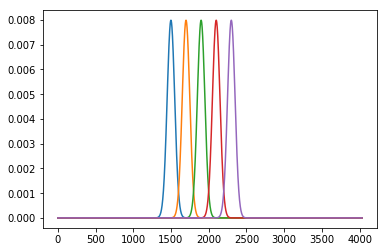

In [60]:
def get_gauss_around(center):
    x_axis = np.linspace(-5,5, num=1000)
    gauss = norm.pdf(x_axis,0,gauss_std)
    base = np.zeros(len(vocab))
    start = max(center - (len(gauss)//2),0)
    end = min(center + (len(gauss)//2),len(base))
    base[start:end] = gauss
    base /= base.sum()
    return base

obj_bases = {}
start = 1500
incr = 200
for obj in obj_categories:
    obj_bases[obj] = get_gauss_around(start)
    start += incr

for base in obj_bases.values():
    plt.plot(base)

    
#small_base = get_gauss_around(500)
#flat_base = get_gauss_around(1000)
#tall_base = get_gauss_around(1500)
#long_base = get_gauss_around(2000)
#big_base = get_gauss_around(2500)
    
#plt.plot(small_base)
#plt.plot(flat_base)
#plt.plot(tall_base)
#plt.plot(long_base)
#plt.plot(big_base)

In [61]:
np.random.rand()

0.42648479001854056

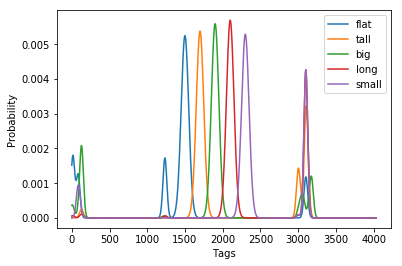

In [76]:
def combine(base,noise,alpha=0.5):
    return (alpha)*base + (1-alpha)*noise

sampling_distributions = {}
alpha = 0.7
for category in obj_categories:
    sampling_distributions[category] = combine(obj_bases[category], obj_smooth_norm_distr[category], 0.65 + alpha * np.random.rand()/10)
    
for category,sampling_distr in sampling_distributions.items():
    plt.plot(sampling_distr, label=category)

#small_sampling = combine(small_base, small_noise, 0.8)
#flat_sampling = combine(flat_base, flat_noise, 0.8)
#tall_sampling = combine(tall_base, tall_noise, 0.8)
#big_sampling = combine(big_base, big_noise, 0.8)
#long_sampling = combine(long_base, long_noise, 0.8)

#plt.plot(small_sampling)
#plt.plot(flat_sampling)
#plt.plot(tall_sampling)
#plt.plot(big_sampling)
#plt.plot(long_sampling)
plt.xlabel("Tags")
plt.ylabel("Probability")
plt.legend()
plt.savefig('/home/frati/Grasping/code/CNN/synteticlabels.pdf',dpi=200)

In [48]:
labels_per_category = {}
for obj, category in obj_to_category.items():
    if category not in labels_per_category:
        labels_per_category[category] = []
    labels_per_category[category] += (label_per_object_thresh[obj])

category_means = {}
for category, labels in labels_per_category.items():
    tot = 0
    lengths = 0
    for label,num in labels:
        lengths += len(label.split(' '))*num
        tot += num 
    category_means[category] = lengths/tot
    print('Category: {:6} avg: {:.2f}'.format(category, lengths/tot))

print()
category_std = {}
for category, labels in labels_per_category.items():
    category_mean = category_means[category]
    err = 0
    tot = 0
    for label,num in labels:
        err += ((len(label.split(' '))-category_mean)**2)*num
        tot += num
    category_std[category] = (err/tot)**(0.5)
    print('Category: {:6} std: {:.2f}'.format(category, (err/tot)**(0.5)))

Category: flat   avg: 2.98
Category: tall   avg: 2.00
Category: big    avg: 2.20
Category: long   avg: 2.01
Category: small  avg: 2.20

Category: flat   std: 0.12
Category: tall   std: 0.00
Category: big    std: 0.49
Category: long   std: 0.12
Category: small  std: 0.40


In [36]:
# base lenght = 5
grasp_factors = { 'flat' : (5,0.25), #   high avg - medium std
                  'tall' : (3,0.1) , #    low avg -    low std
                  'big'  : (4,0.5) , # medium avg -   high std
                  'long' : (3,0.25), #    low avg - medium std
                  'small': (5,0.5)}  # medium avg -   high std

In [37]:
latent_order = np.arange(len(vocab))
np.random.shuffle(latent_order)
print(latent_order)

[3976 1193 2882 ... 1712  994 1466]


In [38]:
def generate_label(category):
    base_length = 7
    n,p =  grasp_factors[category]
    seq_len = base_length + np.random.binomial(n,p)
    sampling_distribution = sampling_distributions[category]
    seq = set()
    while(len(seq)<seq_len):
        seq.add(np.random.choice(len(vocab),p=sampling_distribution))
    
    uniq_tags = set(seq)
    final_seq = sorted(uniq_tags, key = lambda x: latent_order[x])
    return(final_seq)

generate_label('flat')

[1499, 13, 1501, 1498, 1500, 1502, 1235, 3100]

In [39]:
def generate_label_apply(row):
    category = obj_to_category[row['object']]
    base_length = 5
    n,p =  grasp_factors[category]
    seq_len = base_length + np.random.binomial(n,p)
    sampling_distribution = sampling_distributions[category]
    seq = set()
    
    while(len(seq)<seq_len):
        seq.add(np.random.choice(len(vocab),p=sampling_distribution))
        
    uniq_tags = set(seq)
    final_seq = sorted(uniq_tags, key = lambda x: latent_order[x])
    return(final_seq)

df['synth'] = df.apply (lambda row: generate_label_apply(row),axis=1)

In [34]:
df

,trial,new_location,subj,hot,impaired,object,failed,labels,old_location,obj_classes
0,1-subject01-screw_driver-normal_surface-impair...,subject01/1-screw_driver,subject01,False,True,screw_driver,False,"[atu, c2tgn]",/Volumes/Transcend/Tesi/Video_Berlino/Videos/s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2-subject01-plate-normal_surface-impaired_visi...,subject01/2-plate,subject01,False,True,plate,False,"[abg, c3bgn]",/Volumes/Transcend/Tesi/Video_Berlino/Videos/s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3-subject01-chestnut-normal_surface-impaired_v...,subject01/3-chestnut,subject01,False,True,chestnut,False,"[atu, c4tgn]",/Volumes/Transcend/Tesi/Video_Berlino/Videos/s...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4-subject01-shashlik-normal_surface-impaired_v...,subject01/4-shashlik,subject01,False,True,shashlik,False,"[atu, c3tgr]",/Volumes/Transcend/Tesi/Video_Berlino/Videos/s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5-subject01-matchbox-normal_surface-impaired_v...,subject01/5-matchbox,subject01,False,True,matchbox,False,"[atu, c4tgn]",/Volumes/Transcend/Tesi/Video_Berlino/Videos/s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,6-subject01-cd-normal_surface-impaired_vision-...,subject01/6-cd,subject01,False,True,cd,True,"[atu, c4tgn, fp, x, c4tgn, fq, x, fp, x, fp, m...",/Volumes/Transcend/Tesi/Video_Berlino/Videos/s...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,7-subject01-salt_shaker-normal_surface-impaire...,subject01/7-salt_shaker,subject01,False,True,salt_shaker,False,"[atu, c4tun]",/Volumes/Transcend/Tesi/Video_Berlino/Videos/s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,8-subject01-shell-normal_surface-impaired_visi...,subject01/8-shell,subject01,False,True,shell,False,"[atu, c4tgn]",/Volumes/Transcend/Tesi/Video_Berlino/Videos/s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,9-subject01-match-normal_surface-impaired_visi...,subject01/9-match,subject01,False,True,match,True,"[atu, c3tgr, c2tgn, x, mtgl, eg]",/Volumes/Transcend/Tesi/Video_Berlino/Videos/s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
9,10-subject01-cigarette-normal_surface-impaired...,subject01/10-cigarette,subject01,False,True,cigarette,False,"[atu, c2tgr]",/Volumes/Transcend/Tesi/Video_Berlino/Videos/s...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [82]:
new_df = pd.read_pickle('/home/frati/Grasping/Squared/metadata.pkl.compress', compression='gzip')
new_df['synth'] = new_df.apply (lambda row: generate_label_apply(row),axis=1)

In [83]:
#new_df.to_pickle('/home/frati/Grasping/Squared/synth_metadata.pkl.compress', compression = 'gzip')

In [4]:
test = pd.read_pickle('/home/frati/Grasping/Squared/synth_metadata.pkl.compress', compression='gzip')

In [6]:
len([ y for x in list(test['synth']) for y in x])

27085

In [7]:
len(set([ y for x in list(test['synth']) for y in x]))

139

In [6]:
# print labelling in Latex table format
for row in test.iterrows():
    row = row[1]
    synth = list(row['synth'])
    synth = [vocab.ix_to_tag[x] for x in synth]
    stringa = "{} & {} & {} \\\\".format(row['new_location'],row['labels'],synth)
    stringa = stringa.replace('[','')
    stringa = stringa.replace(']','')
    stringa = stringa.replace('_','\_')
    stringa = stringa.replace('-','\_')
    stringa = stringa.replace('/','\_')
    print(stringa)

subject01\_1\_screw\_driver & 'atu', 'c2tgn' & '2cgnt', 'gmrt', '4cns', '5cps', '3cgpt' \\
subject01\_2\_plate & 'abg', 'c3bgn' & '?abw', 'asu', '4bcgp', 'abu', '?abl', 'au', '3crsu' \\
subject01\_3\_chestnut & 'atu', 'c4tgn' & '4cgnt', '4cptu', '4cgpt', '2rux', '2dux' \\
subject01\_4\_shashlik & 'atu', 'c3tgr' & '5cqs', '2cgnt', '4cns', '5cps', '5csw', '4crs' \\
subject01\_5\_matchbox & 'atu', 'c4tgn' & '2nux', '4cgnt', '4cgpt', '2rux', '2cnsu', '4cqtu' \\
subject01\_6\_cd & 'atu', 'c4tgn', 'fp', 'x', 'c4tgn', 'fq', 'x', 'fp', 'x', 'fp', 'mtgl', 'eu' & 'glmt', '4cuw', '4cqu', 'mu', '2cgrt', '4cpu', 'fq' \\
subject01\_7\_salt\_shaker & 'atu', 'c4tun' & '2nux', '3cntu', '4cgpt', '2rux', '2dux' \\
subject01\_8\_shell & 'atu', 'c4tgn' & '3lms', '2cgnt', '3msw', '3cgnt', '3dms', '4cgpt' \\
subject01\_9\_match & 'atu', 'c3tgr', 'c2tgn', 'x', 'mtgl', 'eg' & '3mqs', '3mns', '2cgrt', '3cgnt', '3dms', 'fp', '3cgpt' \\
subject01\_10\_cigarette & 'atu', 'c2tgr' & '5cqs', '2cgrt', '3cgnt', '4cns',

subject06\_111\_button & 'atu', 'c2tgn', 'fp' & 'glmt', '4cuw', 'eg', '4cqu', '4cpu', 'lmtu' \\
subject06\_112\_toy & 'atu', 'c3tun' & '2nux', '2cgnt', '3cgnt', '3cntu', '4cgpt', '2rux' \\
subject06\_113\_cd & 'atu', 'mtul', 'eu' & 'glmt', 'dgmt', '4cuw', 'eg', '4cqu', 'mu', 'fq' \\
subject06\_114\_bowl & 'abu', 'c3bun' & '?abq', '3bcgn', '?abw', 'abu', '?abl', 'agt' \\
subject06\_115\_cigarette & 'atu', 'c2tgr' & '2cgnt', '2cgrt', '3cgnt', '4cns', '5cps', '4crs' \\
subject06\_116\_chestnut & 'atu', 'c3tgn' & '5cptu', '2rux', '3cptu', '3pux', '2dux' \\
subject06\_117\_book & 'atu', 'o', 'mtgd', 'o', 'mtgd', 'fw' & '?abw', '4bcgp', '?abd', 'abu', '?abl', 'au' \\
subject06\_118\_marker & 'atu', 'c3tgr' & '5cqs', '2cgrt', '3cgrt', '4cgrt', '4crs' \\
subject06\_119\_shell & 'atu', 'c2tgn' & '3mqs', '3lms', '2cgnt', '3msw', '2cgrt', '3dms', 'fq' \\
subject06\_120\_shashlik & 'atu', 'c2tgr' & '2cgnt', 'ags', '2cgrt', '3cgnt', '4cns', '5csw', '4crs' \\
subject06\_121\_tape & 'atu', 'c2tgn' & 

subject09\_146\_credit\_card & 'atu', 'mtgl', 'eg' & 'glmt', '4cuw', '2cgnt', '4cqu', 'fq' \\
subject09\_147\_book & 'atu', 'o', 'mtul', 'o', 'c?bur' & '5cptu', '4bcgp', '?abd', '?abp', '?abl', 'agt', '5cnsu' \\
subject09\_148\_comb & 'atu', 'c2tgr', 'fq' & 'dgmt', '4cuw', 'eg', '4cqu', 'mu', '3cgpt' \\
subject09\_149\_game\_card & 'atu', 'mtgl', 'eg' & '4cuw', '2cgnt', '4cqu', '2cgrt', '4cpu', '4clu', 'fq' \\
subject09\_150\_tape & 'atu', 'c2tgn' & '2nux', '2rux', '3cgrt', '3pux', '3cgpt' \\
subject09\_151\_plate & 'abu', 'c2bun' & '?abq', '?abw', '4bcgp', 'abu', '3bcnu', '?abl', '4bcpu' \\
subject09\_152\_salt\_shaker & 'atu', 'c3tun' & '2nux', '2cgrt', '2rux', '2dux', '3cgpt' \\
subject09\_153\_button & 'atu', 'c2tgn', 'fp' & 'eu', 'dgmt', '2cgnt', '4cqu', '4cpu', 'fp' \\
subject09\_154\_coffee\_mug & 'asu', 'c4sun' & '?abq', '?abw', 'asu', '?abd', 'abu', '?abl', 'fq' \\
subject09\_155\_bowl & 'abu', 'c2bun' & '3bcgn', '?abw', '5cgps', 'abu', '?abl', '4cntu', '4bcpu' \\
subject09\_1

subject13\_26\_shell & 'atu', 'c4tgn' & '3lms', '2cgnt', '3msw', '2cgrt', '3cgnt', '3dms', '4cgpt', '3mrs', 'fq', '3cgpt' \\
subject13\_27\_comb & 'atu', 'c2tgr', 'fp' & 'dgmt', '4cuw', 'eg', '4cqu', '4cpu', 'gmrt', '4cdu', 'fq' \\
subject13\_28\_book & 'atu', 'o', 'o', 'fp', 'c4tun' & '?abw', '?abd', 'abu', '3cgns', '?abl', '5cpsu', '?bcgn', '?cpsu' \\
subject13\_29\_coffee\_mug & 'atu', 'c5tur' & '?abw', '4bcgp', 'abu', '3bcnu', '?abl', 'au' \\
subject13\_30\_plate & 'abu', 'c4bgn' & '?abw', '4bcgp', 'abu', '3bcnu', '?abl' \\
subject13\_31\_key & 'atu', 'c3tgr', 'o', 'fp' & '4cuw', 'eg', 'mu', '2cgrt', '4cpu', '3cgnt', '4clu' \\
subject13\_32\_screw\_driver & 'atu', 'c4tgn' & '2cgrt', '4cgnt', '4cns', '5cps', '4crs' \\
subject13\_33\_matchbox & 'atu', 'c4tgr' & '2nux', '4cgpt', '2rux', '3cptu', '2dux' \\
subject13\_34\_shashlik & 'atu', 'c3tgr', 'o', 'c2tgr' & '2cgnt', '2cgrt', '4cns', '5cps', '4crs' \\
subject13\_35\_match & 'atu', 'c3tgr', 'x', 'c3tgn' & '3mqs', '3lms', '2cgnt', '3

subject16\_180\_book & 'atu', 'o', 'fp', 'o', 'c4tun' & '?abq', '?abw', '4bcgp', '?abd', 'abu', '?abl', 'agt', '3cnsu' \\
subject16\_181\_matchbox & 'atu', 'c2tun' & '2nux', '3cgnt', '2rux', '3pux', '2dux', '3cgpt' \\
subject16\_182\_rubber\_band & 'atu', 'c2tun' & '3lms', '2cgnt', '3msw', '2cgrt', '3cgnt', '3dms', '3cgpt' \\
subject16\_183\_glasses & 'atu', 'c2tun' & '2nux', '3cgnt', '2rux', '3cptu', '2dux' \\
subject16\_184\_screw & 'atu', 'c2tun' & '3lms', '2cgnt', '3msw', '2cgrt', '3dms', 'fq', '3cgpt' \\
subject16\_185\_salt\_shaker & 'atu', 'c2tun' & '2nux', '2cgnt', '4cptu', '2rux', '3qux' \\
subject16\_186\_match & 'atu', 'mtul', 'eu' & '3mns', '3lms', '2cgnt', '3msw', '3cgnt', '4cgpt', 'fp', 'fq', '3cgpt' \\
subject16\_187\_cigarette & 'atu', 'c2tun' & 'eg', '2cgrt', '4cns', '5cps', '3cgrt', '4crs' \\
subject16\_188\_comb & 'atu', 'mtud', 'o', 'mtud', 'o', 'mtud', 'eu' & '2cgnt', '4cqu', '4cpu', '4clu', 'fq' \\
subject16\_189\_key & 'atu', 'mtul', 'eu' & 'glmt', '4cuw', 'eg', 

subject19\_40\_screw & 'atu', 'c3tgn' & '3mqs', '3lms', '3msw', '3dms', 'fp', '3mrs', '3cgpt' \\
subject19\_41\_match & 'atu', 'c3tgr' & '3mns', '3lms', '2cgnt', '3cgnt', '3dms', 'fw', '3mrs', '3cgpt' \\
subject19\_42\_key & 'atu', 'c3tgr', 'fp' & '3cnu', '4cuw', '2cgnt', '4cqu', 'mu', '4clu' \\
subject19\_43\_coffee\_mug & 'asg', 'c4sgn' & '?abw', 'ags', 'asu', 'abu', '?abl', '4bcpu' \\
subject19\_44\_glasses & 'atu', 'c3tgr' & '2nux', '2rux', '3cpsu', '2dux', '3cgpt' \\
subject19\_45\_chestnut & 'atu', 'c3tgn' & '2nux', '4cptu', '2rux', '3cptu', '3cgrt', '2dux' \\
subject19\_46\_marker & 'atu', 'c3tgn' & '5cqs', '2cgrt', '4cns', '5cps', '4crs' \\
subject19\_47\_rubber\_band & 'atu', 'c2tgn' & '3lms', '3msw', '3dms', '4cgpt', 'agt', '3mrs', 'fq' \\
subject19\_48\_shell & 'atu', 'c3tgn' & '3mns', '3lms', '2cgnt', '3msw', '3cgnt', '3dms', '3mrs' \\
subject19\_49\_matchbox & 'atu', 'c3tgn' & '2cgrt', '3cntu', '4cgpt', '2rux', '3pux' \\
subject19\_50\_button & 'atu', 'c3tgn', 'fp' & 'glmt

In [88]:
flat_markov = np.zeros((len(vocab),len(vocab)))
flat_starts = np.zeros((len(vocab)))
print(flat_markov.shape)
print(flat_starts.shape)

(4035, 4035)
(4035,)


In [89]:
for i in range(2000):
    seq = generate_label('flat')
    seq.append(vocab.stop)
    flat_starts[seq[0]] += 1
    for i,j in zip(seq,seq[1:]):
        flat_markov[i][j] += 1

In [90]:
flat_starts /= flat_starts.sum()

flat_markov = normalize(flat_markov,axis=1,norm='l1')

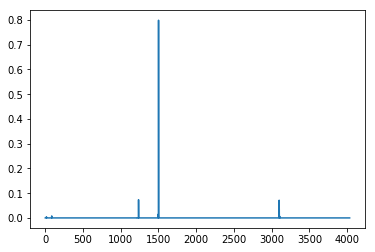

In [91]:
plt.plot(flat_starts)

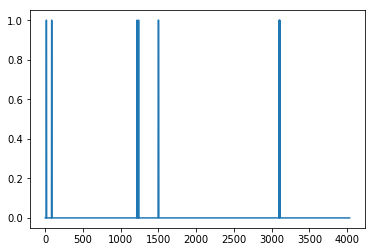

In [92]:
plt.plot(flat_markov.sum(axis=1))

1498


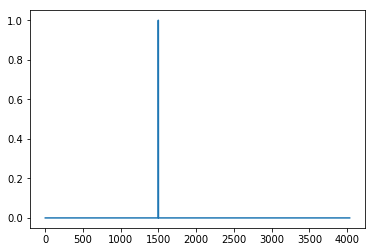

In [93]:
def vectorize(tag,vocab):
    state = np.zeros(len(vocab))
    state[tag] += 1
    return state

def sample(distr,vocab):
    return np.random.choice(len(vocab),p=distr)

vec_test = vectorize(1498,vocab)
plt.plot(vec_test)
tag = sample(vec_test,vocab)
print(tag)

In [105]:
trials = 500
acc = 0

for i in range(trials):
    target_seq = generate_label('flat')
    curr_tag = sample(flat_starts,vocab)
    curr_state = vectorize(curr_tag,vocab)
    correct = 0
    tot = len(target_seq)

    for tag in target_seq:
        #print(tag,curr_tag)
        if(curr_tag == tag):
            correct += 1
        curr_state = curr_state.dot(flat_markov)
        curr_state /= curr_state.sum()
        curr_tag = sample(curr_state,vocab)
        #curr_state = vectorize(curr_tag,vocab)
        
    acc += correct/tot
    
print("Trials {} - Accuracy {}".format(trials, acc/trials))

Trials 500 - Accuracy 0.21798715728715773


In [55]:
def test_category(category,training_samples, test_trials):
    markov = np.zeros((len(vocab),len(vocab)))
    starts = np.zeros((len(vocab)))
    print("Computing Markov for {}".format(category))
    for i in range(training_samples):
        seq = generate_label(category)
        seq.append(vocab.stop)
        starts[seq[0]] += 1
        for i,j in zip(seq,seq[1:]):
            markov[i][j] += 1
    print("Normalizing Markov for {}".format(category))
    starts /= starts.sum()
    markov = normalize(markov,axis=1,norm='l1')

    trials = test_trials
    acc = 0
    print("Testing Markov for {}".format(category))
    for i in range(trials):
        target_seq = generate_label(category)
        curr_tag = sample(starts,vocab)
        curr_state = vectorize(curr_tag,vocab)
        correct = 0
        tot = len(target_seq)

        for tag in target_seq:
            if(curr_tag == tag):
                correct += 1
            curr_state = curr_state.dot(markov)
            curr_state /= curr_state.sum()
            curr_tag = sample(curr_state,vocab)
        acc += correct/tot

    print("Trials {} - Accuracy {}".format(trials, acc/trials))

In [107]:
for obj in obj_categories:
    test_category(obj, 1000, 100)
    print()

Computing Markov for flat
Normalizing Markov for flat
Testing Markov for flat
Trials 100 - Accuracy 0.2128975468975468

Computing Markov for tall
Normalizing Markov for tall
Testing Markov for tall
Trials 100 - Accuracy 0.15071428571428572

Computing Markov for big
Normalizing Markov for big
Testing Markov for big
Trials 100 - Accuracy 0.21672077922077915

Computing Markov for long
Normalizing Markov for long
Testing Markov for long
Trials 100 - Accuracy 0.30501587301587274

Computing Markov for small
Normalizing Markov for small
Testing Markov for small
Trials 100 - Accuracy 0.2634415584415584



In [117]:
obj_categories

{'big': ['book', 'bowl', 'plate', 'coffee_mug'],
 'flat': ['key', 'button', 'cd', 'credit_card', 'game_card', 'comb'],
 'long': ['cigarette', 'marker', 'screw_driver', 'shashlik'],
 'small': ['french_chalk', 'match', 'rubber_band', 'screw', 'shell'],
 'tall': ['glasses', 'matchbox', 'chestnut', 'toy', 'salt_shaker', 'tape']}